# Tensil TCU Demo - ResNet-20 CIFAR

### Import the TCU driver

In [3]:
import sys
sys.path.append('/home/xilinx')

# Needed to run inference on TCU
import time
import numpy as np
import pynq
from pynq import Overlay
from tcu_pynq.driver import Driver
from tcu_pynq.architecture import ultra96

# Needed for unpacking and displaying image data
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

# Needed to run model head in tflite
from functools import reduce
import tflite_runtime.interpreter as tflite
from tcu_pynq.util import div_ceil
import copy

### Read CIFAR-10 images

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

cifar = unpickle('/home/xilinx/cifar-10-batches-py/test_batch')
data = cifar[b'data']
labels = cifar[b'labels']

data = data[10:20]
labels = labels[10:20]

data_norm = data.astype('float32') / 255
data_mean = np.mean(data_norm, axis=0)
data_norm -= data_mean

cifar_meta = unpickle('/home/xilinx/cifar-10-batches-py/batches.meta')
label_names = [b.decode() for b in cifar_meta[b'label_names']]

def show_img(data, n):
    plt.imshow(np.transpose(data[n].reshape((3, 32, 32)), axes=[1, 2, 0]))

def get_img(data, n):
    array_width = 16
    img = np.transpose(data_norm[n].reshape((3, 32, 32)), axes=[1, 2, 0])
    img = np.pad(img, [(0, 0), (0, 0), (0, array_width - 3)], 'constant', constant_values=0)
    return img.reshape((-1, array_width))

def get_label(labels, label_names, n):
    label_idx = labels[n]
    name = label_names[label_idx]
    return (label_idx, name)

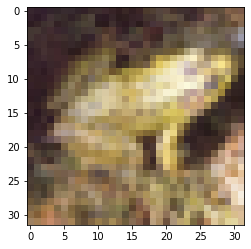

In [5]:
# CIFAR-10 input
n = 9
img = get_img(data, n)
label_idx, label = get_label(labels, label_names, n)
show_img(data, n)

### Configure the fabric and driver

In [6]:
# Specify the bitstream here
bitstream = '/home/xilinx/ultra96-tcu.bit'

In [7]:
overlay = Overlay(bitstream)
tcu = Driver(ultra96, overlay.axi_dma_0)

## Demo: ResNet-20 inference

### Load the model

In [8]:
resnet = '/home/xilinx/resnet20v2_cifar_onnx_ultra96v2.tmodel'
tcu.load_model(resnet)

### Run inference

In [9]:
inputs = {'x:0': img}

start = time.time()
outputs = tcu.run(inputs)
end = time.time()
print("Ran inference in {:.4}s".format(end - start))
print()

classes = outputs['Identity:0'][:10]
result_idx = np.argmax(classes)
result = label_names[result_idx]
print("Output activations:")
print(classes)
print()
print("Result: {} (idx = {})".format(result, result_idx))
print("Actual: {} (idx = {})".format(label, label_idx))

wrote inputs	0.00275s	0.00275s
wrote program	0.0249s	0.0277s
read outputs	0.0013s	0.029s
Ran inference in 0.03043s

Output activations:
[-13.59375    -12.25        -7.90625     -6.21484375  -8.25
 -12.24609375  15.0390625  -15.10546875 -10.71875     -9.1796875 ]

Result: frog (idx = 6)
Actual: frog (idx = 6)
